# Data and Imports

In [1]:



import pandas as pd
import numpy as np
import jsonlines
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch_optimizer as optim
import os

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from importlib import reload
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', '{:0.3f}'.format)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.width = 0
import warnings
import torchvision
warnings.filterwarnings('ignore')

from facebook_hateful_memes_detector.utils.globals import set_global, get_global
set_global("cache_dir", "/home/ahemf/cache/cache")
set_global("dataloader_workers", 4)
set_global("use_autocast", True)
set_global("models_dir", "/home/ahemf/cache/")

from facebook_hateful_memes_detector.utils import read_json_lines_into_df, in_notebook, set_device, my_collate
get_global("cache_dir")
from facebook_hateful_memes_detector.models import Fasttext1DCNNModel, MultiImageMultiTextAttentionEarlyFusionModel, LangFeaturesModel, AlbertClassifer
from facebook_hateful_memes_detector.preprocessing import TextImageDataset, get_datasets, get_image2torchvision_transforms, TextAugment
from facebook_hateful_memes_detector.preprocessing import DefinedRotation, QuadrantCut, ImageAugment
from facebook_hateful_memes_detector.training import *
import facebook_hateful_memes_detector
reload(facebook_hateful_memes_detector)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_device(device)
device


device(type='cuda')

- What Augs are useful
- What Text models perform best

In [2]:

def get_preprocess_text():
    char_level = {"keyboard": 0.1, "char_substitute": 0.4, "char_insert": 0.2, "char_swap": 0.2, 
                  "ocr": 0.0, "char_delete": 0.1}
    char_level = TextAugment([0.1, 0.65, 0.25], char_level)
    word_level = {"split": 0.2,
                 "stopword_insert": 0.5, "word_join": 0.2, "gibberish_insert": 0.0}
    word_level = TextAugment([0.1, 0.9], word_level)
    sentence_level = {"text_rotate": 0.0, "sentence_shuffle": 0.0, 
                      "one_third_cut": 0.3, "half_cut":0.0, "part_select": 0.75}
    sentence_level = TextAugment([0.55, 0.45], sentence_level)
    def process(text):
        text = sentence_level(text)
        text = word_level(text)
        text = char_level(text)
        return text
    return process

preprocess_text = get_preprocess_text()
preprocess_text_test = get_preprocess_text()

data = get_datasets(data_dir="../data/", train_text_transform=preprocess_text, train_image_transform=None, 
                    test_text_transform=None, test_image_transform=None, 
                    cache_images = True, use_images = False, dev=False, test_dev=True,
                    keep_original_text=False, keep_original_image=False, 
                    keep_processed_image=True, keep_torchvision_image=False,)


# Clean text


https://discuss.pytorch.org/t/how-to-implement-torch-optim-lr-scheduler-cosineannealinglr/28797/11

In [3]:


scheduler_init_fn = get_multistep_lr([11, 13], gamma=0.25) # get_cosine_schedule_with_warmup # get_cosine_with_hard_restarts_schedule_with_warmup
scheduler_init_fn = get_constant_schedule_with_warmup(0.3)
# scheduler_init_fn = get_cosine_schedule_with_warmup()
reg_sched = get_regularizer_scheduler()



# Params

In [ ]:
sgd = torch.optim.SGD
sgd_params = dict(lr=2e-2, momentum=0.9, dampening=0, weight_decay=0, nesterov=False)

rangerQH = optim.RangerQH
rangerQHparams = dict(lr=1e-3, betas=(0.9, 0.999), nus=(.7, 1.0),
    weight_decay=0.0,
    k=6,
    alpha=.5,
    decouple_weight_decay=True,
    eps=1e-8,)

adam = torch.optim.Adam
adam_params = params=dict(lr=1e-3, weight_decay=1e-7)

adamw = torch.optim.AdamW
adamw_params = dict(lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-2)

novograd = optim.NovoGrad
novograd_params = dict(lr= 1e-3,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=0,
    grad_averaging=False,
    amsgrad=False,)

qhadam = optim.QHAdam
qhadam_params = dict(lr= 1e-3,
    betas=(0.9, 0.999),
    nus=(1.0, 1.0),
    weight_decay=0,
    decouple_weight_decay=False,
    eps=1e-8,)

radam = optim.RAdam
radam_params = dict(lr= 1e-3,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=0,)

yogi = optim.Yogi
yogi_params = dict(lr= 1e-2,
    betas=(0.9, 0.999),
    eps=1e-3,
    initial_accumulator=1e-6,
    weight_decay=0)




# BERT Models

## Non Ensemble

In [ ]:
adamw = torch.optim.AdamW
adamw_params = dict(lr=5e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-3)
optimizer = adamw
optimizer_params = adamw_params

lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "2": {
                    "lr": optimizer_params["lr"],
                    "finetune": False
                },
                "3": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                }
            }
        },
    }
}

epochs = 24
batch_size = 256
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=768,
                              num_classes=2,
                              gaussian_noise=0.05,
                              dropout=0.05,
                              word_masking_proba=0.1,
                              internal_dims=768,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=0,
                              n_decoders=1,
                              n_tokens_in=96,
                              n_tokens_out=16,
                              featurizer="transformer",
                              model='distilbert-nsp',
                              loss="focal",
                              classification_head="cnn1d", # head_ensemble
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.5, # 0.1
                              attention_drop_proba=0.0,
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched, # reg_sched
    validation_epochs=[1, 4, 7, 9, 11, 14, 17, 19, 23, 27, 31, 34, 37, 41, 44, 47, 51, 54],
    show_model_stats=False,
    sampling_policy="without_replacement")
r2, p2 = results, prfs
results
prfs

# 0.851	0.666


In [ ]:
adamw = torch.optim.AdamW
adamw_params = dict(lr=5e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-3)
optimizer = adamw
optimizer_params = adamw_params

lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "2": {
                    "lr": optimizer_params["lr"],
                    "finetune": False
                },
                "3": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                }
            }
        },
    }
}

epochs = 24
batch_size = 256
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=768,
                              num_classes=2,
                              gaussian_noise=0.05,
                              dropout=0.05,
                              word_masking_proba=0.1,
                              internal_dims=768,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=0,
                              n_decoders=1,
                              n_tokens_in=96,
                              n_tokens_out=16,
                              featurizer="transformer",
                              model='distilbert-nsp',
                              loss="focal",
                              classification_head="cnn1d", # head_ensemble
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.5, # 0.1
                              attention_drop_proba=0.05,
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched, # reg_sched
    validation_epochs=[1, 4, 7, 9, 11, 14, 17, 19, 23, 27, 31, 34, 37, 41, 44, 47, 51, 54],
    show_model_stats=False,
    sampling_policy="without_replacement")
r2, p2 = results, prfs
results
prfs




## Head Ensemble

In [ ]:
adamw = torch.optim.AdamW
adamw_params = dict(lr=5e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-3)
optimizer = adamw
optimizer_params = adamw_params

lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "2": {
                    "lr": optimizer_params["lr"],
                    "finetune": False
                },
                "3": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                }
            }
        },
    }
}

epochs = 24
batch_size = 256
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=768,
                              num_classes=2,
                              gaussian_noise=0.0,
                              dropout=0.05,
                              word_masking_proba=0.1, # 0.1
                              internal_dims=768,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=0,
                              n_decoders=1,
                              n_tokens_in=96,
                              n_tokens_out=16,
                              featurizer="transformer",
                              model='distilbert-nsp',
                              loss="focal",
                              classification_head="head_ensemble", # head_ensemble
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.5, # 0.1
                              attention_drop_proba=0.05,
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched, # reg_sched
    validation_epochs=[17, 27, 32, 37, 41, 44, 54],
    show_model_stats=False,
    sampling_policy="without_replacement",
    prediction_iters=1, evaluate_in_train_mode=False
)
r2, p2 = results, prfs
results
prfs



## Multi-eval Head Ensemble


In [ ]:
adamw = torch.optim.AdamW
adamw_params = dict(lr=5e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-3)
optimizer = adamw
optimizer_params = adamw_params

lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "2": {
                    "lr": optimizer_params["lr"],
                    "finetune": False
                },
                "3": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                }
            }
        },
    }
}

epochs = 20
batch_size = 256
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=768,
                              num_classes=2,
                              gaussian_noise=0.0,
                              dropout=0.1,
                              word_masking_proba=0.1, # 0.1
                              internal_dims=768,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=0,
                              n_decoders=1,
                              n_tokens_in=96,
                              n_tokens_out=16,
                              featurizer="transformer",
                              model='distilbert-nsp',
                              loss="focal",
                              classification_head="head_ensemble", # head_ensemble
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.5, # 0.1
                              attention_drop_proba=0.0,
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched, # reg_sched
    validation_epochs=[17, 27, 32, 37, 41, 44, 54],
    show_model_stats=False,
    sampling_policy="without_replacement",
    prediction_iters=5, evaluate_in_train_mode=True
)
r2, p2 = results, prfs
results
prfs

# 0.799	0.657 gaussian_noise=0.0, dropout=0.05, word_masking_proba=0.1,
# 0.780	0.634 gaussian_noise=0.0, dropout=0.05, word_masking_proba=0.15, 
# 0.806	0.648 gaussian_noise=0.0, dropout=0.02, word_masking_proba=0.1
# 0.803	0.655 gaussian_noise=0.0, dropout=0.1, word_masking_proba=0.1, (0.807	0.657) 0.803	0.653


## Decoder Ensemble

### Train All Params

In [ ]:
adamw = torch.optim.AdamW
adamw_params = dict(lr=5e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-3)
optimizer = adamw
optimizer_params = adamw_params

lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "2": {
                    "lr": optimizer_params["lr"],
                    "finetune": False
                },
                "3": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                }
            }
        },
    }
}

epochs = 24
batch_size = 256
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=768,
                              num_classes=2,
                              gaussian_noise=0.01,
                              dropout=0.025,
                              word_masking_proba=0.1,
                              internal_dims=768,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=0,
                              n_decoders=0,
                              n_tokens_in=96,
                              n_tokens_out=48,
                              featurizer="transformer",
                              model='distilbert-nsp',
                              loss="focal",
                              classification_head="decoder_ensemble", # head_ensemble
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.5, # 0.1
                              attention_drop_proba=0.0,
                              finetune=False,
                              n_classifier_layers=1,
                              n_classifier_decoders=16, # 4
                             ),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched, # reg_sched
    validation_epochs=[17, 27, 34, 41, 47, 51, 54],
    show_model_stats=False,
    sampling_policy="without_replacement",
    prediction_iters=1, evaluate_in_train_mode=False
)
r2, p2 = results, prfs
results
prfs

# 0.854	0.654 0.651 0.646 x2
# MLM = 0.854	0.646
# No focal 0.851	0.647 (0.766	0.556)


In [ ]:
adamw = torch.optim.AdamW
adamw_params = dict(lr=1e-4, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-3)
optimizer = adamw
optimizer_params = adamw_params

lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "2": {
                    "lr": optimizer_params["lr"],
                    "finetune": False
                },
                "3": {
                    "lr": optimizer_params["lr"]/4,
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"]/2,
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"]/2,
                    "finetune": True
                }
            }
        },
    }
}

epochs = 28
batch_size = 256
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=768,
                              num_classes=2,
                              gaussian_noise=0.01,
                              dropout=0.1,
                              word_masking_proba=0.15,
                              internal_dims=768,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=0,
                              n_decoders=0,
                              n_tokens_in=96,
                              n_tokens_out=48,
                              featurizer="transformer",
                              model='distilbert-nsp',
                              loss="focal",
                              classification_head="decoder_ensemble", # head_ensemble
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.5, # 0.1
                              attention_drop_proba=0.0,
                              finetune=False,
                              n_classifier_layers=1,
                              n_classifier_decoders=16, # 4
                             ),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched, # reg_sched
    validation_epochs=[17, 27, 34, 41, 47, 51, 54],
    show_model_stats=False,
    sampling_policy="without_replacement",
    prediction_iters=1, evaluate_in_train_mode=False
)
r3, p3 = results, prfs
results
prfs

# 0.853	0.655 (0.765	0.570)
# 0.863	0.651 (0.778	0.570)


### Train Head First

In [ ]:
def get_preprocess_text():
    char_level = {"keyboard": 0.1, "char_substitute": 0.4, "char_insert": 0.2, "char_swap": 0.2, 
                  "ocr": 0.0, "char_delete": 0.1}
    char_level = TextAugment([0.1, 0.8, 0.1], char_level)
    word_level = {"fasttext": 0.0, "glove_twitter": 0.0, "glove_wiki": 1.0, "word2vec": 0.0, "split": 0.2,
                 "stopword_insert": 0.0, "word_join": 0.2, "word_cutout": 0.0, "gibberish_insert": 0.0}
    word_level = TextAugment([0.1, 0.8, 0.1], word_level, 
                             fasttext_file="wiki-news-300d-1M-subword.bin", idf_file="/home/ahemf/cache/tfidf_terms.csv")
    sentence_level = {"text_rotate": 0.0, "sentence_shuffle": 0.0, 
                      "one_third_cut": 0.3, "half_cut":0.0, "part_select": 0.75}
    sentence_level = TextAugment([0.75, 0.25], sentence_level)
    gibberish = {"gibberish_insert": 0.25, "punctuation_insert": 0.75, 
                 "punctuation_replace": 0.25, "punctuation_strip": 0.5,}
    gibberish = TextAugment([0.75, 0.25], gibberish)
    def process(text):
        text = sentence_level(text)
        text = word_level(text)
        text = char_level(text)
        text = gibberish(text)
        return text
    return process


preprocess_text = get_preprocess_text()
preprocess_text_test = get_preprocess_text()

data = get_datasets(data_dir="../data/", train_text_transform=preprocess_text, train_image_transform=None, 
                    test_text_transform=None, test_image_transform=None, 
                    cache_images = True, use_images = False, dev=False, test_dev=True,
                    keep_original_text=False, keep_original_image=False, 
                    keep_processed_image=True, keep_torchvision_image=False,)


In [ ]:
def aug_sample(sample):
    sample = sample.copy()
    sample.text = preprocess_text(sample.text)
    return sample


In [ ]:
consistency_loss_weight=0.25
num_classes = 2

adamw = torch.optim.AdamW
adamw_params = dict(lr=5e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-2)
optimizer_class = adamw
optimizer_params = adamw_params

lr_strategy = {
    "model": {
        "finetune": False,
    }
}

epochs = 4
batch_size = 256
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=768,
                              num_classes=2,
                              gaussian_noise=0.01,
                              dropout=0.05,
                              word_masking_proba=0.15,
                              internal_dims=768,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=0,
                              n_decoders=0,
                              n_tokens_in=96,
                              n_tokens_out=48,
                              featurizer="transformer",
                              model='distilbert-smclr',
                              loss="focal",
                              classification_head="decoder_ensemble", # head_ensemble
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.25,
                              attention_drop_proba=0.01,
                              finetune=False,
                              n_classifier_layers=1,
                              n_classifier_decoders=16, # 4
                             ),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer_class,
                         optimiser_params=optimizer_params)


model, optimizer = model_fn()
kfold = False
results, prfs = train_validate_ntimes(
    (model, optimizer),
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=None, # reg_sched
    validation_epochs=[15, 27, 34, 41, 47, 51, 54],
    show_model_stats=False,
    sampling_policy=None,
    prediction_iters=1, evaluate_in_train_mode=False,
    consistency_loss_weight=consistency_loss_weight, num_classes=num_classes,
    aug_1=aug_sample, aug_2=aug_sample,
)
r2, p2 = results, prfs
results
prfs

adamw_params = dict(lr=1e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-3)
optimizer_params = adamw_params
lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "2": {
                    "lr": optimizer_params["lr"],
                    "finetune": False
                },
                "3": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                }
            }
        },
    }
}

_ = group_wise_finetune(model, lr_strategy)
params_conf, _ = group_wise_lr(model, lr_strategy)
optimizer = optimizer_class(params_conf, **optimizer_params)


epochs = 24
batch_size=128
kfold = False
results, prfs = train_validate_ntimes(
    (model, optimizer),
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=None, # reg_sched
    validation_epochs=[7, 15, 21, 31, 41, 46, 51, 54, 62],
    show_model_stats=False,
    accumulation_steps=2,
    sampling_policy=None,
    prediction_iters=1, evaluate_in_train_mode=False,
    consistency_loss_weight=consistency_loss_weight, num_classes=num_classes,
    aug_1=aug_sample, aug_2=aug_sample,
)
r4, p4 = results, prfs
results
prfs

# 48-96
# 0.842	0.658 (0.767	0.572)
# 0.847	0.652 (0.766	0.574)

# Very high W/C
# 0.841	0.652 (0.760	0.570)
# 0.840	0.653 (0.759	0.576)
# 0.839	0.650 (0.760	0.568)
# 0.842	0.645 (0.762	0.570)
# 0.839	0.653 (0.761	0.574)


# # No stops + Very High W/C Reg
# 0.836	0.652 (0.754	0.588)
# 0.839	0.650 (0.762	0.576)

# 48-64 0.0 gauss
# 0.848	0.658 (0.768	0.578)
# 0.849	0.656 (0.766	0.570)


# SimCLR
# 0.856	0.657 (0.767	0.590)
# 0.859	0.654 (0.778	0.568)

# 0.828	0.651 (0.765	0.566)
# Replace multiple puncts with space and strip


In [ ]:
preds, probas = [], []
dataset = convert_dataframe_to_dataset(data["dev"], data["metadata"], True)
from tqdm.auto import tqdm, trange
for i in trange(100):
    proba_list, all_probas_list, predictions_list, labels_list = generate_predictions(model, 128, dataset)
    probas.append(all_probas_list)
    preds.append(predictions_list)
    
from collections import Counter
preds_voted = [Counter(p).most_common()[0][0] for p in zip(*preds)]
probas_mean = torch.tensor(probas).mean(0)
pred_probas = probas_mean.max(dim=1).indices
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report
from sklearn.metrics import precision_recall_fscore_support, accuracy_score


print(accuracy_score(labels_list, preds_voted))
print(accuracy_score(labels_list, pred_probas))
print(roc_auc_score(labels_list, probas_mean[:, 1].tolist(), multi_class="ovo", average="macro"))


## Multi-eval decoder ensemble

# Predict

In [4]:
# For UDA major keep consistency_loss_weight low since we have less labels and weightage of label prediction should be good
# For UDA minor keep consistency loss weight high
minor_consistency_loss_weight=0.1
major_consistency_loss_weight=5.0
num_classes = 2

adamw = torch.optim.AdamW
optimizer_params = dict(lr=5e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-2)
optimizer_class = adamw



In [5]:

model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=768,
                              num_classes=2,
                              gaussian_noise=0.01,
                              dropout=0.01, # 0.05
                              word_masking_proba=0.15,
                              whole_word_masking=True,
                              uda=True,
                              internal_dims=768,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=0,
                              n_decoders=0,
                              n_tokens_in=96,
                              n_tokens_out=48,
                              featurizer="transformer",
                              model='distilbert-smclr',
                              loss="focal",
                              classification_head="decoder_ensemble", # head_ensemble
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.25, # 0.5
                              attention_drop_proba=0.0, # 0.1
                              finetune=False,
                              n_classifier_layers=1,
                              n_classifier_decoders=16, # 4
                             ),
                         per_param_opts_fn=dict(),
                         optimiser_class=optimizer_class,
                         optimiser_params=optimizer_params)

model, _ = model_fn()

## Round Robin Fine tuning of distilbert-smclr and this model as well


Pick stored Model /home/ahemf/cache/distilbert-smclr Model Class =  <class 'transformers.modeling_roberta.RobertaModel'> Tokenizer Class =  <class 'transformers.tokenization_roberta.RobertaTokenizer'>


## UDA Major

In [6]:
import random
def get_preprocess_text():
    char_level = {"keyboard": 0.1, "char_substitute": 0.4, "char_insert": 0.2, "char_swap": 0.2, 
                  "ocr": 0.0, "char_delete": 0.1}
    char_level = TextAugment([0.1, 0.2, 0.5, 0.2], char_level)
    word_level = {"split": 0.2,
                 "stopword_insert": 0.0, "word_join": 0.2, "punctuation_continue": 0.5, "punctuation_replace": 0.25,}
    word_level = TextAugment([0.1, 0.2, 0.5, 0.2], word_level, 
                             fasttext_file="wiki-news-300d-1M-subword.bin")
    sentence_level = {"text_rotate": 0.0, "sentence_shuffle": 0.0, "glove_wiki": 0.75, "glove_twitter": 0.75,"word_cutout": 0.5,
                      "one_third_cut": 0.25, "half_cut":0.0, "part_select": 0.25, }
    sentence_level = TextAugment([0.1, 0.5, 0.4], sentence_level, idf_file="/home/ahemf/cache/tfidf_terms.csv"
                                )
    gibberish = {"gibberish_insert": 0.25, "punctuation_insert": 0.75, 
                 "punctuation_replace": 0.25, "punctuation_strip": 0.5,}
    gibberish = TextAugment([0.25, 0.75], gibberish)
    translation = {"dab":1.0, "punctuation_insert": 0.01}
    translation = TextAugment([0.0, 1.0], translation, dab_file="/home/ahemf/cache/fdab.csv")
    def process(text, **kwargs):
        if random.random() < 0.25:
            text = sentence_level(text, **kwargs)
        else:
            text = translation(text, **kwargs)
        text = word_level(text, **kwargs)
        text = char_level(text, **kwargs)
        text = gibberish(text, **kwargs)
        return text
    return process


preprocess_text = get_preprocess_text()
preprocess_text_test = get_preprocess_text()

def aug_sample(sample):
    sample = sample.copy()
    sample.text = preprocess_text(sample.text, identifier=sample.id)
    return sample

data = get_datasets(data_dir="../data/", train_text_transform=preprocess_text, train_image_transform=None, 
                    test_text_transform=None, test_image_transform=None, 
                    cache_images = True, use_images = False, dev=False, test_dev=True,
                    keep_original_text=False, keep_original_image=False, 
                    keep_processed_image=True, keep_torchvision_image=False,)


data["train"] = data["train"].sample(frac=1.0)
df_train = data["train"].copy(deep=True)
df_test = data["test"].copy(deep=True)
data["test"] = pd.concat((data["train"].iloc[len(data["train"])//4:].drop(columns=["label"]), data["test"]))
data["train"] = data["train"].iloc[:len(data["train"])//4]

data["train"].shape
data["test"].shape
data["dev"].shape




(2125, 4)

(7375, 3)

(500, 4)

Autocast =  True Epochs =  8 Divisor = 2 Examples = 5000 Batch Size =  128
Training Samples =  10000 Weighted Sampling =  True Num Batches =  40 Accumulation steps =  1


Exception for:  keyboard | Original Text '' '' Final Text '' '' | ['keyboard' 'char_insert' 'char_swap'] argument of type 'NoneType' is not iterable

Epoch =  1 Loss = nan LR = 0.00001250


Exception for:  keyboard | Original Text ''' '''' Final Text ''' '''' | ['keyboard'] argument of type 'NoneType' is not iterable

Epoch =  2 Loss = 0.412320 LR = 0.00002500



scores =  {'map': '0.4841', 'acc': '0.6522', 'auc': '0.6333'}



scores =  {'map': '0.5170', 'acc': '0.5120', 'auc': '0.5263'}
Epoch =  2 Train = ['48.41', '65.22', '63.33'] Val = ['51.70', '51.20', '52.63']



Epoch =  3 Loss = 0.476901 LR = 0.00003000



Epoch =  4 Loss = 0.395502 LR = 0.00003000



Epoch =  5 Loss = nan LR = 0.00003000



Epoch =  6 Loss = nan LR = 0.00003000



Epoch =  7 Loss = 0.452241 LR = 0.00003000



Epoch =  8 Loss = 0.336337 LR = 0.00003000



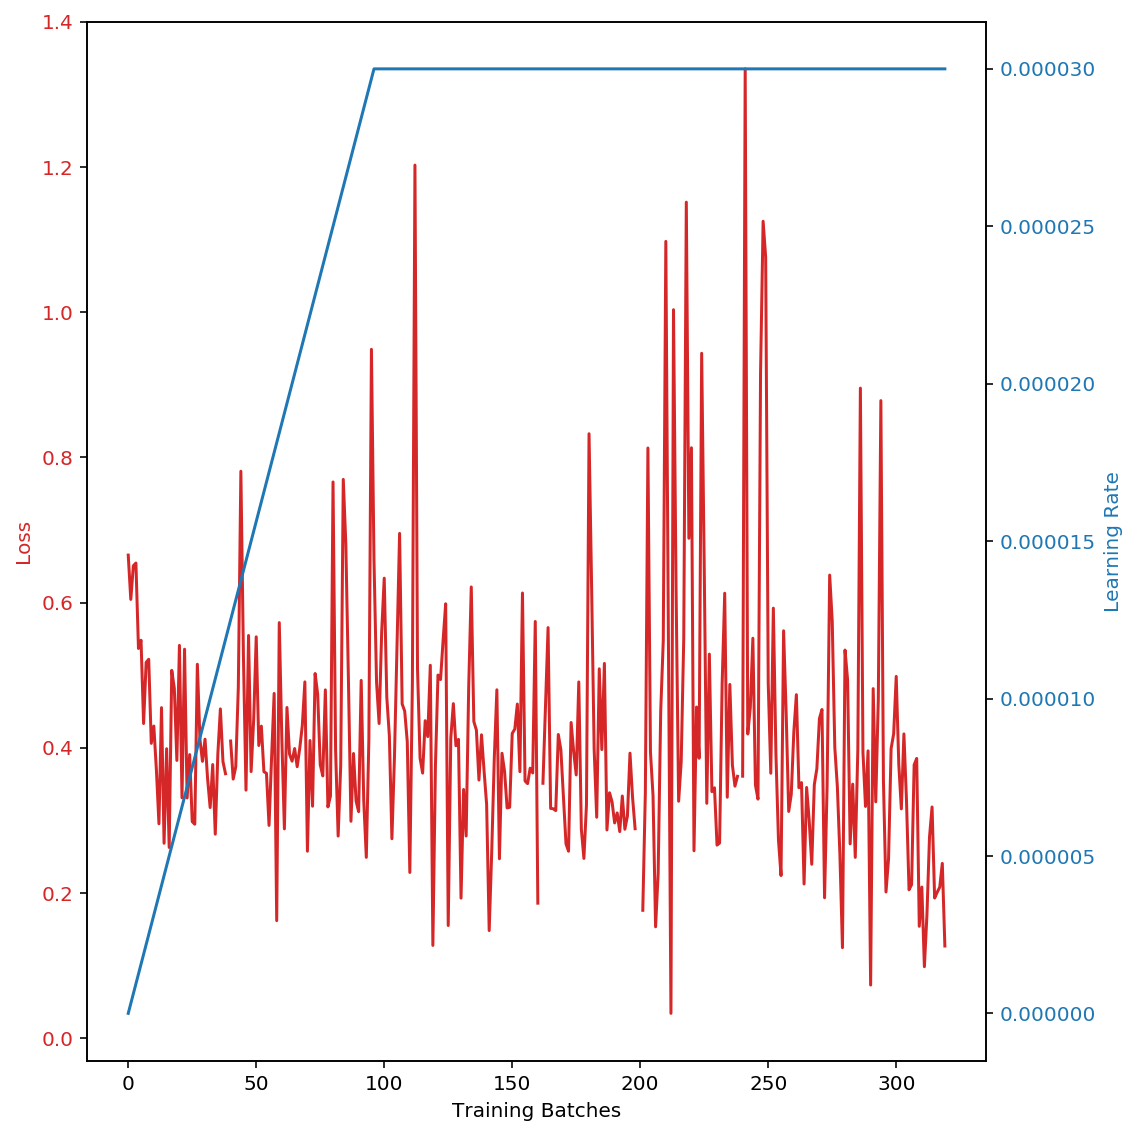

Proba       Preds    
         min   max   min max
Labels                      
0      0.426 0.671     0   1
1      0.426 0.679     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.580,"[0.4196663796901703, 0.5803335905075073]",1,1,0.520,"[0.4797283113002777, 0.5202717185020447]",1,0,0.658,"[0.34235072135925293, 0.6576492786407471]",1,1
1,0.644,"[0.3563980460166931, 0.6436019539833069]",1,1,0.511,"[0.4885633587837219, 0.5114367008209229]",1,0,0.637,"[0.36320075392723083, 0.6367992162704468]",1,1
2,0.471,"[0.5285782814025879, 0.4714217483997345]",0,0,0.540,"[0.4595049321651459, 0.5404950380325317]",1,0,0.642,"[0.3581297695636749, 0.6418702602386475]",1,1
3,0.474,"[0.5264198780059814, 0.47358015179634094]",0,1,0.644,"[0.35639122128486633, 0.643608808517456]",1,0,0.630,"[0.3700282573699951, 0.6299717426300049]",1,0
4,0.553,"[0.4467865526676178, 0.553213357925415]",1,0,0.601,"[0.3988662660121918, 0.6011337041854858]",1,0,0.458,"[0.5416533350944519, 0.4583466947078705]",0,0


Predicted,0,1,Actual Counts,Recall %
Actual,,,,
0,20,230,250.000,8.000
1,14,236,250.000,94.000
Predicted Counts,34,466,500.000,nan
Precision %,58,50,nan,nan


scores =  {'map': '0.5569', 'acc': '0.5120', 'auc': '0.5530'}



scores =  {'map': '0.5349', 'acc': '0.3934', 'auc': '0.6516'}


train   val
mean_or_std metric               
mean        map       0.535 0.557
            accuracy  0.393 0.512
            auc       0.652 0.553
std         map       0.000 0.000
            accuracy  0.000 0.000
            auc       0.000 0.000

train                             val                     
    precision recall    f1  supoort precision recall    f1 supoort
neg     0.821  0.068 0.125 1361.000     0.588  0.080 0.141 250.000
pos     0.370  0.974 0.536  764.000     0.506  0.944 0.659 250.000

Autocast =  True Epochs =  100 Divisor = 2 Examples = 5000 Batch Size =  128
Training Samples =  10000 Weighted Sampling =  True Num Batches =  40 Accumulation steps =  8



Epoch =  1 Loss = nan LR = 0.00000033



Epoch =  2 Loss = nan LR = 0.00000067



scores =  {'map': '0.5329', 'acc': '0.4682', 'auc': '0.6498'}



scores =  {'map': '0.5569', 'acc': '0.5180', 'auc': '0.5526'}
Epoch =  2 Train = ['53.29', '46.82', '64.98'] Val = ['55.69', '51.80', '55.26']


Exception for:  keyboard | Original Text ''. ''''' Final Text ' ' . ' ' ' ' ' | ['char_substitute' 'keyboard'] argument of type 'NoneType' is not iterable

Epoch =  3 Loss = nan LR = 0.00000100



Epoch =  4 Loss = 0.277523 LR = 0.00000133



Epoch =  5 Loss = nan LR = 0.00000167



Epoch =  6 Loss = 0.253349 LR = 0.00000200



Epoch =  7 Loss = nan LR = 0.00000233



scores =  {'map': '0.5416', 'acc': '0.6287', 'auc': '0.6558'}



scores =  {'map': '0.5575', 'acc': '0.5300', 'auc': '0.5545'}
Epoch =  7 Train = ['54.16', '62.87', '65.58'] Val = ['55.75', '53.00', '55.45']



Epoch =  8 Loss = nan LR = 0.00000267



Epoch =  9 Loss = nan LR = 0.00000300



Epoch =  10 Loss = nan LR = 0.00000333



Epoch =  11 Loss = nan LR = 0.00000367



Epoch =  12 Loss = 0.249080 LR = 0.00000400


Exception for:  keyboard | Original Text "'!""!$ '@"' Final Text " ' ! " " ! $ ' @ " ' | ['char_substitute' 'keyboard' 'char_delete'] argument of type 'NoneType' is not iterable

Epoch =  13 Loss = nan LR = 0.00000433



Epoch =  14 Loss = nan LR = 0.00000467



Epoch =  15 Loss = nan LR = 0.00000500



scores =  {'map': '0.5847', 'acc': '0.6762', 'auc': '0.6915'}



scores =  {'map': '0.5686', 'acc': '0.5360', 'auc': '0.5713'}
Epoch =  15 Train = ['58.47', '67.62', '69.15'] Val = ['56.86', '53.60', '57.13']



Epoch =  16 Loss = nan LR = 0.00000533



Epoch =  17 Loss = 0.251738 LR = 0.00000567



Epoch =  18 Loss = 0.255681 LR = 0.00000600



Epoch =  19 Loss = nan LR = 0.00000633



Epoch =  20 Loss = 0.254960 LR = 0.00000667



Epoch =  21 Loss = nan LR = 0.00000700



scores =  {'map': '0.6087', 'acc': '0.7016', 'auc': '0.7117'}



scores =  {'map': '0.5738', 'acc': '0.5380', 'auc': '0.5811'}
Epoch =  21 Train = ['60.87', '70.16', '71.17'] Val = ['57.38', '53.80', '58.11']



Epoch =  22 Loss = nan LR = 0.00000733



Epoch =  23 Loss = nan LR = 0.00000767



Epoch =  24 Loss = 0.260393 LR = 0.00000800



Epoch =  25 Loss = nan LR = 0.00000833



Epoch =  26 Loss = nan LR = 0.00000867



scores =  {'map': '0.6268', 'acc': '0.7096', 'auc': '0.7288'}



scores =  {'map': '0.5863', 'acc': '0.5360', 'auc': '0.5909'}
Epoch =  26 Train = ['62.68', '70.96', '72.88'] Val = ['58.63', '53.60', '59.09']



Epoch =  27 Loss = nan LR = 0.00000900



Epoch =  28 Loss = 0.238734 LR = 0.00000933



Epoch =  29 Loss = nan LR = 0.00000967



Epoch =  30 Loss = 0.241122 LR = 0.00001000



scores =  {'map': '0.6337', 'acc': '0.6104', 'auc': '0.7380'}



scores =  {'map': '0.5854', 'acc': '0.5720', 'auc': '0.5933'}
Epoch =  30 Train = ['63.37', '61.04', '73.80'] Val = ['58.54', '57.20', '59.33']



Epoch =  31 Loss = nan LR = 0.00001000



Epoch =  32 Loss = nan LR = 0.00001000



Epoch =  33 Loss = 0.245598 LR = 0.00001000



Epoch =  34 Loss = nan LR = 0.00001000



Epoch =  35 Loss = nan LR = 0.00001000



scores =  {'map': '0.6480', 'acc': '0.7115', 'auc': '0.7509'}



scores =  {'map': '0.5943', 'acc': '0.5260', 'auc': '0.6082'}
Epoch =  35 Train = ['64.80', '71.15', '75.09'] Val = ['59.43', '52.60', '60.82']



Epoch =  36 Loss = 0.239628 LR = 0.00001000



Epoch =  37 Loss = nan LR = 0.00001000



Epoch =  38 Loss = nan LR = 0.00001000



Epoch =  39 Loss = nan LR = 0.00001000



Epoch =  40 Loss = nan LR = 0.00001000



Epoch =  41 Loss = nan LR = 0.00001000



scores =  {'map': '0.6565', 'acc': '0.7285', 'auc': '0.7573'}



scores =  {'map': '0.5931', 'acc': '0.5340', 'auc': '0.5984'}
Epoch =  41 Train = ['65.65', '72.85', '75.73'] Val = ['59.31', '53.40', '59.84']



Epoch =  42 Loss = nan LR = 0.00001000



Epoch =  43 Loss = 0.229694 LR = 0.00001000



Epoch =  44 Loss = 0.246220 LR = 0.00001000



Epoch =  45 Loss = 0.230094 LR = 0.00001000



Epoch =  46 Loss = nan LR = 0.00001000



scores =  {'map': '0.6665', 'acc': '0.4212', 'auc': '0.7660'}



scores =  {'map': '0.5930', 'acc': '0.5360', 'auc': '0.6057'}
Epoch =  46 Train = ['66.65', '42.12', '76.60'] Val = ['59.30', '53.60', '60.57']



Epoch =  47 Loss = nan LR = 0.00001000



Epoch =  48 Loss = 0.221268 LR = 0.00001000



Epoch =  49 Loss = nan LR = 0.00001000



Epoch =  50 Loss = nan LR = 0.00001000



Epoch =  51 Loss = nan LR = 0.00001000



scores =  {'map': '0.6648', 'acc': '0.7073', 'auc': '0.7675'}



scores =  {'map': '0.5895', 'acc': '0.5620', 'auc': '0.6076'}
Epoch =  51 Train = ['66.48', '70.73', '76.75'] Val = ['58.95', '56.20', '60.76']



Epoch =  52 Loss = nan LR = 0.00001000



Epoch =  53 Loss = 0.242587 LR = 0.00001000



Epoch =  54 Loss = 0.210048 LR = 0.00001000



scores =  {'map': '0.6621', 'acc': '0.7271', 'auc': '0.7666'}



scores =  {'map': '0.5975', 'acc': '0.5240', 'auc': '0.6098'}
Epoch =  54 Train = ['66.21', '72.71', '76.66'] Val = ['59.75', '52.40', '60.98']



Epoch =  55 Loss = nan LR = 0.00001000



Epoch =  56 Loss = 0.225573 LR = 0.00001000



Epoch =  57 Loss = 0.210696 LR = 0.00001000


Exception for:  keyboard | Original Text '' '' Final Text ' ' ' ' | ['char_substitute' 'keyboard'] argument of type 'NoneType' is not iterable

Epoch =  58 Loss = 0.219745 LR = 0.00001000



Epoch =  59 Loss = 0.210289 LR = 0.00001000



Epoch =  60 Loss = nan LR = 0.00001000



scores =  {'map': '0.6566', 'acc': '0.6499', 'auc': '0.7657'}



scores =  {'map': '0.6063', 'acc': '0.5920', 'auc': '0.6161'}
Epoch =  60 Train = ['65.66', '64.99', '76.57'] Val = ['60.63', '59.20', '61.61']



Epoch =  61 Loss = 0.217713 LR = 0.00001000



Epoch =  62 Loss = 0.219498 LR = 0.00001000



Epoch =  63 Loss = nan LR = 0.00001000



Epoch =  64 Loss = nan LR = 0.00001000



Epoch =  65 Loss = nan LR = 0.00001000



scores =  {'map': '0.6643', 'acc': '0.7308', 'auc': '0.7736'}



scores =  {'map': '0.6031', 'acc': '0.5300', 'auc': '0.6221'}
Epoch =  65 Train = ['66.43', '73.08', '77.36'] Val = ['60.31', '53.00', '62.21']



Epoch =  66 Loss = nan LR = 0.00001000



Epoch =  67 Loss = nan LR = 0.00001000



Epoch =  68 Loss = nan LR = 0.00001000



Epoch =  69 Loss = nan LR = 0.00001000



Epoch =  70 Loss = nan LR = 0.00001000



scores =  {'map': '0.6706', 'acc': '0.7016', 'auc': '0.7776'}



scores =  {'map': '0.6027', 'acc': '0.5780', 'auc': '0.6220'}
Epoch =  70 Train = ['67.06', '70.16', '77.76'] Val = ['60.27', '57.80', '62.20']



Epoch =  71 Loss = nan LR = 0.00001000



Epoch =  72 Loss = 0.205516 LR = 0.00001000



Epoch =  73 Loss = 0.211834 LR = 0.00001000



Epoch =  74 Loss = 0.229662 LR = 0.00001000



Epoch =  75 Loss = nan LR = 0.00001000



scores =  {'map': '0.6731', 'acc': '0.6071', 'auc': '0.7818'}



scores =  {'map': '0.6068', 'acc': '0.5940', 'auc': '0.6274'}
Epoch =  75 Train = ['67.31', '60.71', '78.18'] Val = ['60.68', '59.40', '62.74']



Epoch =  76 Loss = 0.223334 LR = 0.00001000


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [7]:
lr_strategy = {
    "model": {
        "finetune": False,
    }
}

optimizer_params = dict(lr=3e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-3)
_ = group_wise_finetune(model, lr_strategy)
params_conf, _ = group_wise_lr(model, lr_strategy)
optimizer = optimizer_class(params_conf, **optimizer_params)

epochs = 4
batch_size = 128
results, prfs, _ = train_validate_ntimes(
    (model, optimizer),
    data,
    batch_size,
    epochs,
    accumulation_steps=1,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched, # reg_sched
    validation_epochs=[2, 15, 27, 34, 41, 47, 51, 54],
    show_model_stats=False,
    sampling_policy="uda_without_replacement",
    prediction_iters=1, evaluate_in_train_mode=False,
    consistency_loss_weight=major_consistency_loss_weight, num_classes=num_classes,
    aug_1=aug_sample, aug_2=aug_sample,
)
r2, p2 = results, prfs
results
prfs

adamw_params = dict(lr=1e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-3)
optimizer_params = adamw_params
lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "2": {
                    "lr": optimizer_params["lr"],
                    "finetune": False
                },
                "3": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                }
            }
        },
    }
}

_ = group_wise_finetune(model, lr_strategy)
params_conf, _ = group_wise_lr(model, lr_strategy)
optimizer = optimizer_class(params_conf, **optimizer_params)


epochs = 50
batch_size=128
kfold = False
submission, text_model, val_stats_uda_major_1 = train_and_predict(
    (model, optimizer),
    data,
    batch_size,
    epochs,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched, # reg_sched
    validation_epochs=[2, 7, 15, 21, 26, 30, 35, 41, 46, 51, 54, 60, 65, 70, 75, 80, 85, 90, 95, 100],
    show_model_stats=False,
    accumulation_steps=8,
    sampling_policy="uda_without_replacement",
    consistency_loss_weight=major_consistency_loss_weight, num_classes=num_classes,
    aug_1=aug_sample, aug_2=aug_sample,
)



(2125, 4)

(7375, 3)

(500, 4)

Autocast =  True Epochs =  100 Divisor = 2 Examples = 5000 Batch Size =  128
Training Samples =  10000 Weighted Sampling =  True Num Batches =  40 Accumulation steps =  8



Epoch =  1 Loss = nan LR = 0.00001000



Epoch =  2 Loss = 0.188179 LR = 0.00001000



scores =  {'map': '0.6155', 'acc': '0.6414', 'auc': '0.7292'}



scores =  {'map': '0.5962', 'acc': '0.5920', 'auc': '0.6180'}
Epoch =  2 Train = ['61.55', '64.14', '72.92'] Val = ['59.62', '59.20', '61.80']


Exception for:  keyboard | Original Text * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *


Epoch =  4 Loss = 0.183750 LR = 0.00001000



Epoch =  5 Loss = nan LR = 0.00001000



Epoch =  6 Loss = nan LR = 0.00001000



Epoch =  7 Loss = 0.198994 LR = 0.00001000



scores =  {'map': '0.6254', 'acc': '0.5115', 'auc': '0.7370'}



scores =  {'map': '0.6033', 'acc': '0.5740', 'auc': '0.6203'}
Epoch =  7 Train = ['62.54', '51.15', '73.70'] Val = ['60.33', '57.40', '62.03']



Epoch =  8 Loss = nan LR = 0.00001000



Epoch =  9 Loss = 0.195164 LR = 0.00001000



Epoch =  10 Loss = 0.190149 LR = 0.00001000



Epoch =  11 Loss = nan LR = 0.00001000



Epoch =  12 Loss = nan LR = 0.00001000



Epoch =  13 Loss = 0.203125 LR = 0.00001000



Epoch =  14 Loss = 0.191585 LR = 0.00001000



Epoch =  15 Loss = 0.194372 LR = 0.00001000



scores =  {'map': '0.6384', 'acc': '0.6965', 'auc': '0.7456'}



scores =  {'map': '0.6146', 'acc': '0.5700', 'auc': '0.6308'}
Epoch =  15 Train = ['63.84', '69.65', '74.56'] Val = ['61.46', '57.00', '63.08']



Epoch =  16 Loss = 0.193460 LR = 0.00001000



Epoch =  17 Loss = nan LR = 0.00001000



Epoch =  18 Loss = 0.197486 LR = 0.00001000



Epoch =  19 Loss = nan LR = 0.00001000



Epoch =  20 Loss = nan LR = 0.00001000


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Epoch =  48 Loss = nan LR = 0.00001000



Epoch =  49 Loss = 0.191624 LR = 0.00001000



Epoch =  50 Loss = nan LR = 0.00001000



Epoch =  51 Loss = nan LR = 0.00001000



scores =  {'map': '0.6730', 'acc': '0.7252', 'auc': '0.7767'}



scores =  {'map': '0.6050', 'acc': '0.5520', 'auc': '0.6288'}
Epoch =  51 Train = ['67.30', '72.52', '77.67'] Val = ['60.50', '55.20', '62.88']



Epoch =  52 Loss = 0.189317 LR = 0.00001000



Epoch =  53 Loss = nan LR = 0.00001000


Exception for:  keyboard | Original Text ','$ @$$' Final Text ','$ @$$' | ['keyboard'] argument of type 'NoneType' is not iterable

Epoch =  54 Loss = nan LR = 0.00001000



scores =  {'map': '0.6800', 'acc': '0.7219', 'auc': '0.7784'}



scores =  {'map': '0.6059', 'acc': '0.5600', 'auc': '0.6292'}
Epoch =  54 Train = ['68.00', '72.19', '77.84'] Val = ['60.59', '56.00', '62.92']



Epoch =  55 Loss = nan LR = 0.00001000


Exception for:  keyboard | Original Text ',,$@ @"' Final Text ',,$@ @"' | ['keyboard'] argument of type 'NoneType' is not iterable

Epoch =  56 Loss = nan LR = 0.00001000



Epoch =  57 Loss = nan LR = 0.00001000



Epoch =  58 Loss = 0.194121 LR = 0.00001000



Epoch =  59 Loss = nan LR = 0.00001000



Epoch =  60 Loss = nan LR = 0.00001000



scores =  {'map': '0.6859', 'acc': '0.5515', 'auc': '0.7797'}



scores =  {'map': '0.6084', 'acc': '0.5860', 'auc': '0.6273'}
Epoch =  60 Train = ['68.59', '55.15', '77.97'] Val = ['60.84', '58.60', '62.73']



Epoch =  61 Loss = nan LR = 0.00001000



Epoch =  62 Loss = nan LR = 0.00001000



Epoch =  63 Loss = 0.178350 LR = 0.00001000



Epoch =  64 Loss = 0.180123 LR = 0.00001000



Epoch =  65 Loss = nan LR = 0.00001000



scores =  {'map': '0.6894', 'acc': '0.7205', 'auc': '0.7844'}



scores =  {'map': '0.6100', 'acc': '0.5740', 'auc': '0.6303'}
Epoch =  65 Train = ['68.94', '72.05', '78.44'] Val = ['61.00', '57.40', '63.03']



Epoch =  66 Loss = nan LR = 0.00001000



Epoch =  67 Loss = nan LR = 0.00001000


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Epoch =  92 Loss = nan LR = 0.00001000



Epoch =  93 Loss = nan LR = 0.00001000


Exception for:  keyboard | Original Text '...' ' Final Text ' . . . ' ' | ['char_delete' 'keyboard'] argument of type 'NoneType' is not iterable

Epoch =  94 Loss = nan LR = 0.00001000



Epoch =  95 Loss = nan LR = 0.00001000



scores =  {'map': '0.7139', 'acc': '0.7233', 'auc': '0.8032'}



scores =  {'map': '0.6092', 'acc': '0.5780', 'auc': '0.6327'}
Epoch =  95 Train = ['71.39', '72.33', '80.32'] Val = ['60.92', '57.80', '63.27']



Epoch =  96 Loss = nan LR = 0.00001000



Epoch =  97 Loss = 0.178170 LR = 0.00001000



Epoch =  98 Loss = nan LR = 0.00001000



Epoch =  99 Loss = 0.165322 LR = 0.00001000



Epoch =  100 Loss = nan LR = 0.00001000



scores =  {'map': '0.7205', 'acc': '0.7341', 'auc': '0.8089'}



scores =  {'map': '0.6075', 'acc': '0.5840', 'auc': '0.6358'}
Epoch =  100 Train = ['72.05', '73.41', '80.89'] Val = ['60.75', '58.40', '63.58']



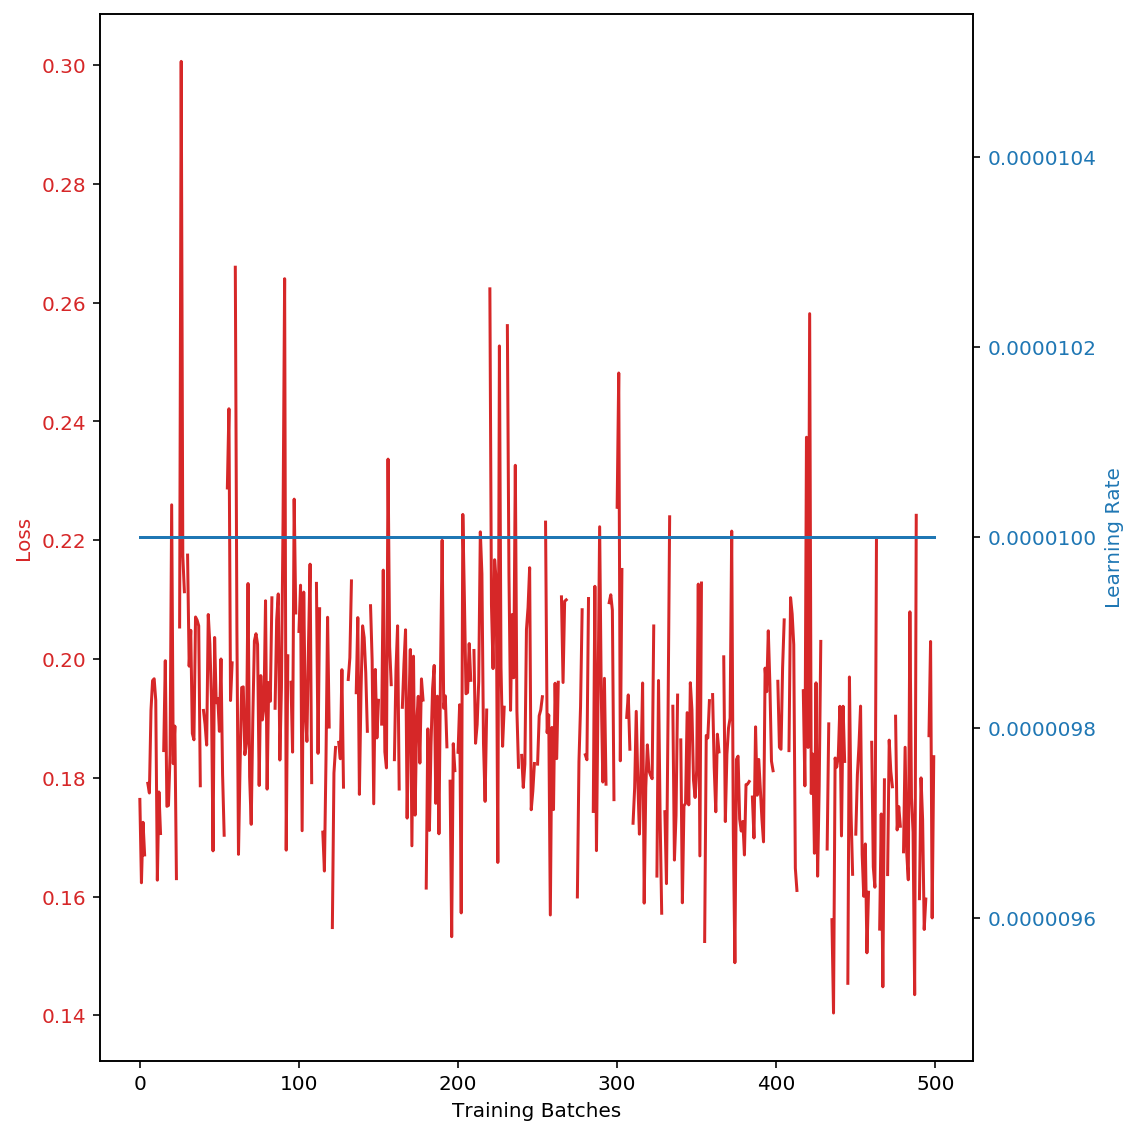

In [8]:
data["train"] = df_train
data["test"] = df_test
data["test"] = pd.concat((data["train"].iloc[:len(data["train"]) - len(data["train"])//4].drop(columns=["label"]), data["test"]))
data["train"] = data["train"].iloc[len(data["train"]) - len(data["train"])//4:]

data["train"].shape
data["test"].shape
data["dev"].shape

epochs = 50
batch_size=128
kfold = False
submission, text_model, val_stats_uda_major_2 = train_and_predict(
    (model, optimizer),
    data,
    batch_size,
    epochs,
    scheduler_init_fn=None,
    model_call_back=reg_sched, # reg_sched
    validation_epochs=[2, 7, 15, 21, 26, 30, 35, 41, 46, 51, 54, 60, 65, 70, 75, 80, 85, 90, 95, 100],
    show_model_stats=False,
    accumulation_steps=8,
    sampling_policy="uda_without_replacement",
    consistency_loss_weight=major_consistency_loss_weight, num_classes=num_classes,
    aug_1=aug_sample, aug_2=aug_sample,
)




## UDA Minor

In [9]:
# import random
# def get_preprocess_text():
#     char_level = {"keyboard": 0.1, "char_substitute": 0.4, "char_insert": 0.2, "char_swap": 0.2, 
#                   "ocr": 0.0, "char_delete": 0.1}
#     char_level = TextAugment([0.1, 0.6, 0.3], char_level)
#     word_level = {"split": 0.2,
#                  "stopword_insert": 0.0, "word_join": 0.2, "punctuation_continue": 0.5}
#     word_level = TextAugment([0.1, 0.6, 0.3], word_level, 
#                              fasttext_file="wiki-news-300d-1M-subword.bin")
#     sentence_level = {"text_rotate": 0.0, "sentence_shuffle": 0.0, "glove_twitter": 0.75,"word_cutout": 0.5,
#                       "one_third_cut": 0.25, "half_cut":0.0, "part_select": 0.25, }
#     sentence_level = TextAugment([0.25, 0.75], sentence_level, idf_file="/home/ahemf/cache/tfidf_terms.csv"
#                                 )
#     gibberish = {"gibberish_insert": 0.25, "punctuation_insert": 0.75, 
#                  "punctuation_replace": 0.25, "punctuation_strip": 0.5,}
#     gibberish = TextAugment([0.5, 0.5], gibberish)
#     translation = {"dab":1.0, "punctuation_insert": 0.01}
#     translation = TextAugment([0.0, 1.0], translation, dab_file="/home/ahemf/cache/fdab.csv")
#     def process(text, **kwargs):
#         if random.random() < 0.5:
#             text = sentence_level(text, **kwargs)
#         else:
#             text = translation(text, **kwargs)
#         text = word_level(text, **kwargs)
#         text = char_level(text, **kwargs)
#         text = gibberish(text, **kwargs)
#         return text
#     return process


# preprocess_text = get_preprocess_text()
# preprocess_text_test = get_preprocess_text()

data = get_datasets(data_dir="../data/", train_text_transform=preprocess_text, train_image_transform=None, 
                    test_text_transform=None, test_image_transform=None, 
                    cache_images = True, use_images = False, dev=False, test_dev=False,
                    keep_original_text=False, keep_original_image=False, 
                    keep_processed_image=True, keep_torchvision_image=False,)

def aug_sample(sample):
    sample = sample.copy()
    sample.text = preprocess_text(sample.text, identifier=sample.id)
    return sample



In [ ]:
# Dont run
epochs = 4
batch_size = 128
results, prfs, _ = train_validate_ntimes(
    (model, optimizer),
    data,
    batch_size,
    epochs,
    accumulation_steps=1,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched, # reg_sched
    validation_epochs=[2, 15, 27, 34, 41, 47, 51, 54],
    show_model_stats=False,
    sampling_policy="uda_without_replacement",
    prediction_iters=1, evaluate_in_train_mode=False,
    consistency_loss_weight=minor_consistency_loss_weight, num_classes=num_classes,
    aug_1=aug_sample, aug_2=aug_sample,
)
r2, p2 = results, prfs
results
prfs

adamw_params = dict(lr=1e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-3)
optimizer_params = adamw_params
lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "2": {
                    "lr": optimizer_params["lr"],
                    "finetune": False
                },
                "3": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                }
            }
        },
    }
}

_ = group_wise_finetune(model, lr_strategy)
params_conf, _ = group_wise_lr(model, lr_strategy)
optimizer = optimizer_class(params_conf, **optimizer_params)

Autocast =  True Epochs =  120 Divisor = 2 Examples = 5250 Batch Size =  128
Training Samples =  10500 Weighted Sampling =  True Num Batches =  42 Accumulation steps =  8
[WARN]: Number of training batches not divisible by accumulation steps, some training batches will be wasted due to this.



Epoch =  1 Loss = 0.243041 LR = 0.00000028



Epoch =  2 Loss = 0.241108 LR = 0.00000056



scores =  {'map': '0.6536', 'acc': '0.7134', 'auc': '0.7579'}



scores =  {'map': '0.6075', 'acc': '0.5540', 'auc': '0.6359'}
Epoch =  2 Train = ['65.36', '71.34', '75.79'] Val = ['60.75', '55.40', '63.59']



Epoch =  3 Loss = 0.237211 LR = 0.00000083



Epoch =  4 Loss = 0.238440 LR = 0.00000111



Epoch =  5 Loss = 0.239940 LR = 0.00000139



Epoch =  6 Loss = 0.237454 LR = 0.00000167


Exception for:  keyboard | Original Text '" ' Final Text ' " ' | ['char_substitute' 'keyboard'] argument of type 'NoneType' is not iterable

Epoch =  7 Loss = 0.239328 LR = 0.00000194



scores =  {'map': '0.6550', 'acc': '0.7172', 'auc': '0.7591'}



scores =  {'map': '0.6100', 'acc': '0.5500', 'auc': '0.6381'}
Epoch =  7 Train = ['65.50', '71.72', '75.91'] Val = ['61.00', '55.00', '63.81']



Epoch =  8 Loss = 0.241055 LR = 0.00000222


Exception for:  keyboard | Original Text '! "' Final Text '! "' | ['keyboard' 'char_swap'] argument of type 'NoneType' is not iterable

Epoch =  9 Loss = 0.239643 LR = 0.00000250



Epoch =  10 Loss = 0.240356 LR = 0.00000278



Epoch =  11 Loss = 0.242333 LR = 0.00000306



Epoch =  12 Loss = 0.243792 LR = 0.00000333



Epoch =  13 Loss = 0.244841 LR = 0.00000361



Epoch =  14 Loss = 0.241381 LR = 0.00000389



Epoch =  15 Loss = 0.246382 LR = 0.00000417



scores =  {'map': '0.6599', 'acc': '0.7222', 'auc': '0.7629'}



scores =  {'map': '0.6156', 'acc': '0.5460', 'auc': '0.6427'}
Epoch =  15 Train = ['65.99', '72.22', '76.29'] Val = ['61.56', '54.60', '64.27']



Epoch =  16 Loss = 0.241919 LR = 0.00000444


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Epoch =  36 Loss = 0.244954 LR = 0.00001000



Epoch =  37 Loss = 0.243328 LR = 0.00001000



Epoch =  38 Loss = 0.251822 LR = 0.00001000



Epoch =  39 Loss = 0.247099 LR = 0.00001000



Epoch =  40 Loss = 0.244049 LR = 0.00001000



Epoch =  41 Loss = 0.246924 LR = 0.00001000



scores =  {'map': '0.6823', 'acc': '0.7269', 'auc': '0.7762'}



scores =  {'map': '0.6270', 'acc': '0.5480', 'auc': '0.6561'}
Epoch =  41 Train = ['68.23', '72.69', '77.62'] Val = ['62.70', '54.80', '65.61']



Epoch =  42 Loss = 0.249638 LR = 0.00001000



Epoch =  43 Loss = nan LR = 0.00001000



Epoch =  44 Loss = 0.245180 LR = 0.00001000



Epoch =  45 Loss = 0.246697 LR = 0.00001000



Epoch =  46 Loss = 0.243446 LR = 0.00001000



scores =  {'map': '0.6878', 'acc': '0.7310', 'auc': '0.7793'}



scores =  {'map': '0.6312', 'acc': '0.5540', 'auc': '0.6622'}
Epoch =  46 Train = ['68.78', '73.10', '77.93'] Val = ['63.12', '55.40', '66.22']



Epoch =  47 Loss = 0.246122 LR = 0.00001000



Epoch =  48 Loss = 0.241780 LR = 0.00001000


Exception for:  keyboard | Original Text "..?... $$' Final Text " . . ? . . . $ $ ' | ['char_swap' 'keyboard'] argument of type 'NoneType' is not iterable

Epoch =  49 Loss = 0.244232 LR = 0.00001000



Epoch =  50 Loss = 0.245618 LR = 0.00001000



Epoch =  51 Loss = 0.242178 LR = 0.00001000



scores =  {'map': '0.6916', 'acc': '0.7208', 'auc': '0.7817'}



scores =  {'map': '0.6321', 'acc': '0.5880', 'auc': '0.6638'}
Epoch =  51 Train = ['69.16', '72.08', '78.17'] Val = ['63.21', '58.80', '66.38']



Epoch =  52 Loss = 0.243456 LR = 0.00001000


Exception for:  keyboard | Original Text "'"""'' ..'' Final Text " ' " " " ' ' . . ' ' | ['char_substitute' 'keyboard'] argument of type 'NoneType' is not iterable


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Epoch =  75 Loss = 0.241831 LR = 0.00001000



scores =  {'map': '0.7070', 'acc': '0.7352', 'auc': '0.7932'}



scores =  {'map': '0.6455', 'acc': '0.5840', 'auc': '0.6825'}
Epoch =  75 Train = ['70.70', '73.52', '79.32'] Val = ['64.55', '58.40', '68.25']



Epoch =  76 Loss = 0.238743 LR = 0.00001000



Epoch =  77 Loss = 0.244422 LR = 0.00001000



Epoch =  78 Loss = 0.241696 LR = 0.00001000



Epoch =  79 Loss = 0.234922 LR = 0.00001000



Epoch =  80 Loss = 0.242829 LR = 0.00001000



scores =  {'map': '0.7105', 'acc': '0.7351', 'auc': '0.7953'}



scores =  {'map': '0.6452', 'acc': '0.5860', 'auc': '0.6829'}
Epoch =  80 Train = ['71.05', '73.51', '79.53'] Val = ['64.52', '58.60', '68.29']



Epoch =  81 Loss = 0.240518 LR = 0.00001000



Epoch =  82 Loss = 0.237699 LR = 0.00001000



Epoch =  83 Loss = 0.239944 LR = 0.00001000



Epoch =  84 Loss = 0.239429 LR = 0.00001000



Epoch =  85 Loss = 0.241748 LR = 0.00001000



scores =  {'map': '0.7124', 'acc': '0.7379', 'auc': '0.7971'}



scores =  {'map': '0.6429', 'acc': '0.5680', 'auc': '0.6828'}
Epoch =  85 Train = ['71.24', '73.79', '79.71'] Val = ['64.29', '56.80', '68.28']



Epoch =  86 Loss = 0.236771 LR = 0.00001000



Epoch =  87 Loss = 0.239417 LR = 0.00001000



Epoch =  88 Loss = 0.234702 LR = 0.00001000



Epoch =  89 Loss = 0.237879 LR = 0.00001000



Epoch =  90 Loss = 0.238062 LR = 0.00001000


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Epoch =  109 Loss = 0.231419 LR = 0.00001000



Epoch =  110 Loss = 0.233463 LR = 0.00001000



scores =  {'map': '0.7290', 'acc': '0.7433', 'auc': '0.8088'}



scores =  {'map': '0.6554', 'acc': '0.6080', 'auc': '0.6981'}
Epoch =  110 Train = ['72.90', '74.33', '80.88'] Val = ['65.54', '60.80', '69.81']



Epoch =  111 Loss = 0.228898 LR = 0.00001000



Epoch =  112 Loss = 0.226378 LR = 0.00001000



Epoch =  113 Loss = 0.231035 LR = 0.00001000



Epoch =  114 Loss = 0.224160 LR = 0.00001000



Epoch =  115 Loss = 0.227177 LR = 0.00001000



scores =  {'map': '0.7324', 'acc': '0.7491', 'auc': '0.8115'}



scores =  {'map': '0.6598', 'acc': '0.5840', 'auc': '0.7013'}
Epoch =  115 Train = ['73.24', '74.91', '81.15'] Val = ['65.98', '58.40', '70.13']



Epoch =  116 Loss = 0.231505 LR = 0.00001000



Epoch =  117 Loss = 0.230212 LR = 0.00001000



Epoch =  118 Loss = 0.225674 LR = 0.00001000



Epoch =  119 Loss = 0.225486 LR = 0.00001000


Exception for:  keyboard | Original Text * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * ** * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 


scores =  {'map': '0.7356', 'acc': '0.7541', 'auc': '0.8143'}



scores =  {'map': '0.6584', 'acc': '0.5800', 'auc': '0.7021'}
Epoch =  120 Train = ['73.56', '75.41', '81.43'] Val = ['65.84', '58.00', '70.21']



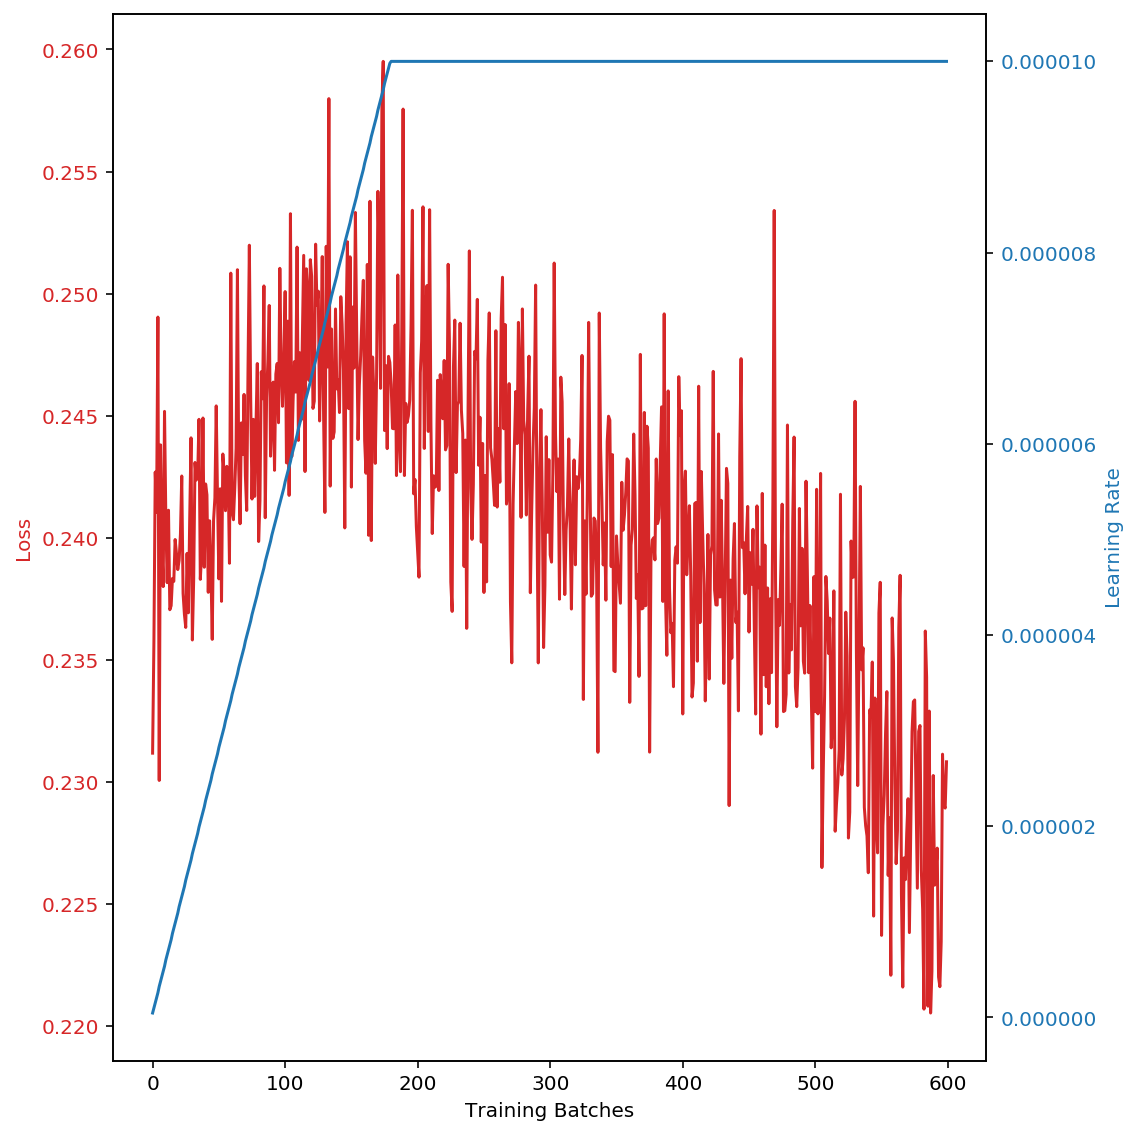

,id,proba,label
269,36128,0.444,0
48,1936,0.480,0
993,36421,0.522,1
28,8261,0.441,0
75,78092,0.524,1


In [10]:

epochs = 60
batch_size=128
kfold = False
submission, text_model, val_stats = train_and_predict(
    (model, optimizer),
    data,
    batch_size,
    epochs,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched, # reg_sched
    validation_epochs=[2, 7, 15, 21, 26, 30, 35, 41, 46, 51, 54, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120],
    show_model_stats=False,
    accumulation_steps=8,
    sampling_policy="uda_without_replacement",
    consistency_loss_weight=minor_consistency_loss_weight, num_classes=num_classes,
    aug_1=aug_sample, aug_2=aug_sample,
)
submission.to_csv("submission.csv",index=False)
submission.sample(5)

# 0.722	0.729
# Epoch =  7 Train = ['65.58', '70.96', '76.21'] Val = ['63.17', '59.00', '65.39']
# Epoch =  15 Train = ['71.83', '74.37', '80.36'] Val = ['65.55', '56.40', '69.26']
# Epoch =  21 Train = ['74.72', '76.03', '82.47'] Val = ['67.23', '58.80', '70.98']
# Epoch =  24 Train = ['76.21', '76.28', '83.56'] Val = ['68.91', '61.60', '72.54']
# Epoch =  27 Train = ['77.27', '76.88', '84.36'] Val = ['70.52', '62.20', '73.87']
# Epoch =  30 Train = ['78.28', '77.12', '85.13'] Val = ['71.45', '62.40', '74.26']

Autocast =  True Epochs =  30 Divisor = 2 Examples = 5250 Batch Size =  128
Training Samples =  10500 Weighted Sampling =  True Num Batches =  42 Accumulation steps =  8
[WARN]: Number of training batches not divisible by accumulation steps, some training batches will be wasted due to this.



Epoch =  1 Loss = 0.226780 LR = 0.00001000



Epoch =  2 Loss = 0.227427 LR = 0.00001000



scores =  {'map': '0.7370', 'acc': '0.7454', 'auc': '0.8150'}



scores =  {'map': '0.6596', 'acc': '0.6060', 'auc': '0.7033'}
Epoch =  2 Train = ['73.70', '74.54', '81.50'] Val = ['65.96', '60.60', '70.33']



Epoch =  3 Loss = 0.230021 LR = 0.00001000


Exception for:  keyboard | Original Text '"@$" '@' Final Text '"@$" '@' | ['keyboard'] argument of type 'NoneType' is not iterable

Epoch =  4 Loss = 0.231829 LR = 0.00001000



Epoch =  5 Loss = 0.229137 LR = 0.00001000



scores =  {'map': '0.7381', 'acc': '0.7533', 'auc': '0.8162'}



scores =  {'map': '0.6641', 'acc': '0.5980', 'auc': '0.7066'}
Epoch =  5 Train = ['73.81', '75.33', '81.62'] Val = ['66.41', '59.80', '70.66']



Epoch =  6 Loss = 0.237844 LR = 0.00001000


Exception for:  keyboard | Original Text ""?"..$ !"@!' Final Text ""?"..$ !"@!' | ['keyboard' 'char_swap'] argument of type 'NoneType' is not iterable

Epoch =  7 Loss = 0.240953 LR = 0.00001000



scores =  {'map': '0.7391', 'acc': '0.7392', 'auc': '0.8167'}



scores =  {'map': '0.6643', 'acc': '0.6140', 'auc': '0.7070'}
Epoch =  7 Train = ['73.91', '73.92', '81.67'] Val = ['66.43', '61.40', '70.70']



Epoch =  8 Loss = 0.231464 LR = 0.00001000


Exception for:  keyboard | Original Text * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *


Epoch =  10 Loss = 0.233115 LR = 0.00001000



scores =  {'map': '0.7407', 'acc': '0.7497', 'auc': '0.8182'}



scores =  {'map': '0.6657', 'acc': '0.6060', 'auc': '0.7103'}
Epoch =  10 Train = ['74.07', '74.97', '81.82'] Val = ['66.57', '60.60', '71.03']



Epoch =  11 Loss = 0.232328 LR = 0.00001000


Exception for:  keyboard | Original Text ''''' ' Final Text ' ' ' ' ' ' | ['char_swap' 'keyboard'] argument of type 'NoneType' is not iterable

Epoch =  12 Loss = 0.231804 LR = 0.00001000



Epoch =  13 Loss = 0.231029 LR = 0.00001000



Epoch =  14 Loss = 0.236323 LR = 0.00001000



Epoch =  15 Loss = 0.233828 LR = 0.00001000



scores =  {'map': '0.7434', 'acc': '0.7504', 'auc': '0.8201'}



scores =  {'map': '0.6673', 'acc': '0.6160', 'auc': '0.7106'}
Epoch =  15 Train = ['74.34', '75.04', '82.01'] Val = ['66.73', '61.60', '71.06']



Epoch =  16 Loss = 0.233464 LR = 0.00001000



Epoch =  17 Loss = 0.231068 LR = 0.00001000



Epoch =  18 Loss = 0.233750 LR = 0.00001000



Epoch =  19 Loss = 0.233562 LR = 0.00001000



Epoch =  20 Loss = 0.236814 LR = 0.00001000



scores =  {'map': '0.7455', 'acc': '0.7490', 'auc': '0.8210'}



scores =  {'map': '0.6703', 'acc': '0.6160', 'auc': '0.7110'}
Epoch =  20 Train = ['74.55', '74.90', '82.10'] Val = ['67.03', '61.60', '71.10']



Epoch =  21 Loss = 0.235451 LR = 0.00001000



Epoch =  22 Loss = 0.236136 LR = 0.00001000



Epoch =  23 Loss = 0.230668 LR = 0.00001000



Epoch =  24 Loss = 0.231234 LR = 0.00001000


Exception for:  keyboard | Original Text * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *


Epoch =  26 Loss = 0.227563 LR = 0.00001000



scores =  {'map': '0.7485', 'acc': '0.7477', 'auc': '0.8235'}



scores =  {'map': '0.6762', 'acc': '0.6240', 'auc': '0.7164'}
Epoch =  26 Train = ['74.85', '74.77', '82.35'] Val = ['67.62', '62.40', '71.64']



Epoch =  27 Loss = 0.225222 LR = 0.00001000



Epoch =  28 Loss = 0.225253 LR = 0.00001000



Epoch =  29 Loss = 0.225631 LR = 0.00001000



Epoch =  30 Loss = 0.221780 LR = 0.00001000



scores =  {'map': '0.7505', 'acc': '0.7576', 'auc': '0.8255'}



scores =  {'map': '0.6818', 'acc': '0.6240', 'auc': '0.7220'}
Epoch =  30 Train = ['75.05', '75.76', '82.55'] Val = ['68.18', '62.40', '72.20']



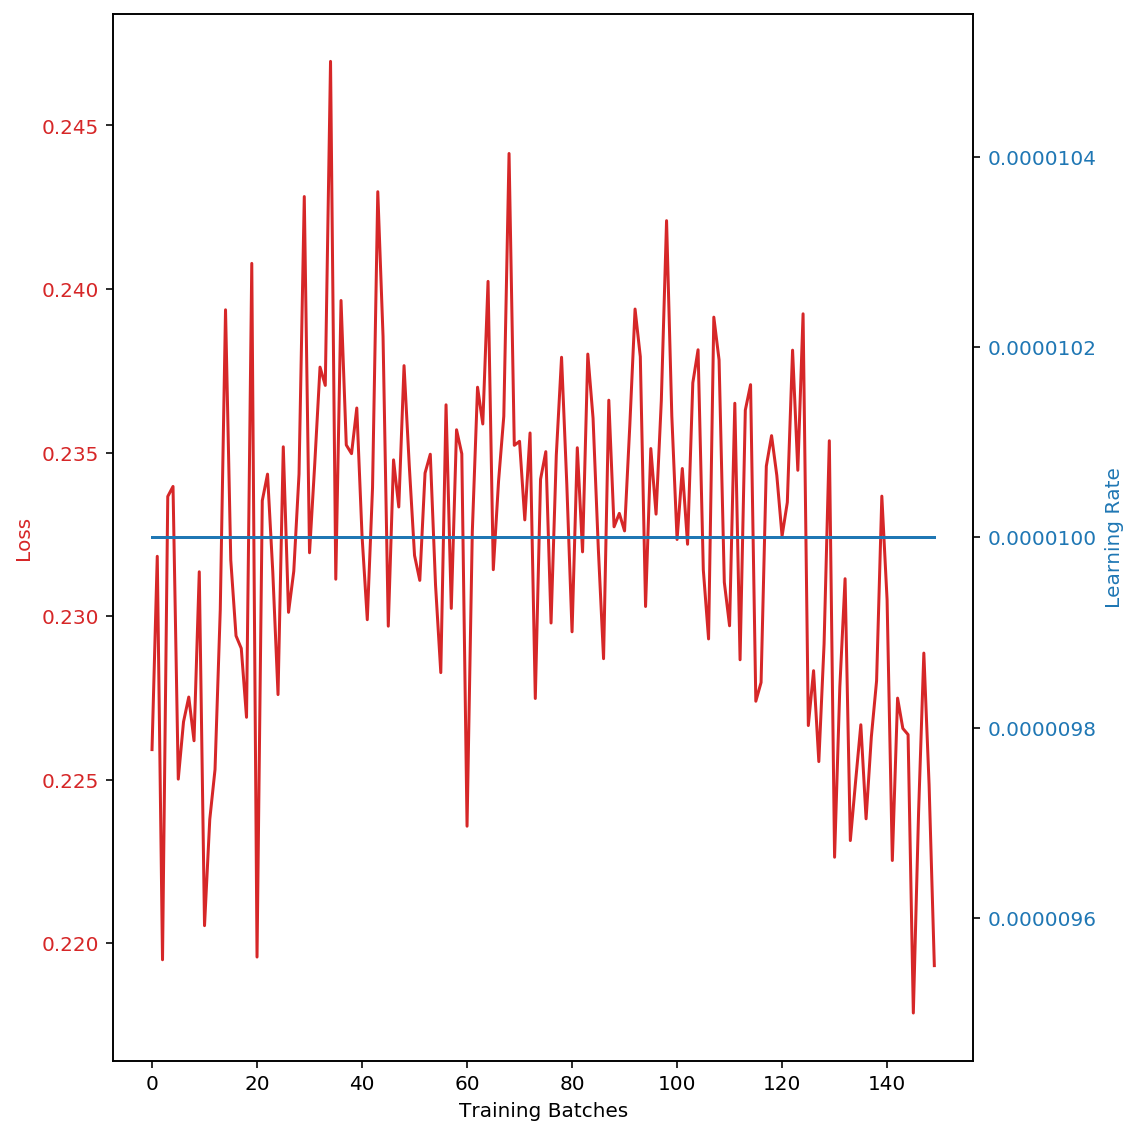

,id,proba,label
982,61054,0.407,0
394,16598,0.596,1
433,71063,0.513,1
211,45610,0.449,0
766,7915,0.460,0


In [11]:
epochs = 15
batch_size=128
kfold = False
submission, text_model, val_stats = train_and_predict(
    (model, optimizer),
    data,
    batch_size,
    epochs,
    scheduler_init_fn=None,
    model_call_back=reg_sched, # reg_sched
    validation_epochs=[2, 5, 7, 10, 15, 20, 26, 30, 35, 40, 46, 51, 54, 60, 65, 70],
    show_model_stats=False,
    accumulation_steps=8,
    sampling_policy="uda_without_replacement",
    consistency_loss_weight=minor_consistency_loss_weight, num_classes=num_classes,
    aug_1=aug_sample, aug_2=aug_sample,
)
submission.to_csv("submission_2.csv",index=False)
submission.sample(5)


Autocast =  True Epochs =  30 Divisor = 2 Examples = 5250 Batch Size =  128
Training Samples =  10500 Weighted Sampling =  True Num Batches =  42 Accumulation steps =  16
[WARN]: Number of training batches not divisible by accumulation steps, some training batches will be wasted due to this.



Epoch =  1 Loss = 0.223730 LR = 0.00001000



Epoch =  2 Loss = 0.225674 LR = 0.00001000



scores =  {'map': '0.7512', 'acc': '0.7451', 'auc': '0.8260'}



scores =  {'map': '0.6808', 'acc': '0.6360', 'auc': '0.7218'}
Epoch =  2 Train = ['75.12', '74.51', '82.60'] Val = ['68.08', '63.60', '72.18']



Epoch =  3 Loss = 0.228577 LR = 0.00001000



Epoch =  4 Loss = 0.227677 LR = 0.00001000



Epoch =  5 Loss = 0.226637 LR = 0.00001000



scores =  {'map': '0.7520', 'acc': '0.7509', 'auc': '0.8265'}



scores =  {'map': '0.6811', 'acc': '0.6340', 'auc': '0.7217'}
Epoch =  5 Train = ['75.20', '75.09', '82.65'] Val = ['68.11', '63.40', '72.17']



Epoch =  6 Loss = 0.228956 LR = 0.00001000



Epoch =  7 Loss = 0.227387 LR = 0.00001000



scores =  {'map': '0.7521', 'acc': '0.7468', 'auc': '0.8264'}



scores =  {'map': '0.6800', 'acc': '0.6320', 'auc': '0.7208'}
Epoch =  7 Train = ['75.21', '74.68', '82.64'] Val = ['68.00', '63.20', '72.08']



Epoch =  8 Loss = 0.234351 LR = 0.00001000



Epoch =  9 Loss = 0.232477 LR = 0.00001000



Epoch =  10 Loss = 0.233317 LR = 0.00001000



scores =  {'map': '0.7522', 'acc': '0.7408', 'auc': '0.8262'}



scores =  {'map': '0.6814', 'acc': '0.6320', 'auc': '0.7197'}
Epoch =  10 Train = ['75.22', '74.08', '82.62'] Val = ['68.14', '63.20', '71.97']



Epoch =  11 Loss = 0.231455 LR = 0.00001000



Epoch =  12 Loss = 0.230012 LR = 0.00001000



Epoch =  13 Loss = 0.231856 LR = 0.00001000


Exception for:  keyboard | Original Text ",""'?.@ ?$' Final Text " , " " ' ? . @ ? $ ' | ['char_delete' 'keyboard'] argument of type 'NoneType' is not iterable

Epoch =  14 Loss = 0.231576 LR = 0.00001000



Epoch =  15 Loss = 0.230796 LR = 0.00001000



scores =  {'map': '0.7534', 'acc': '0.7542', 'auc': '0.8273'}



scores =  {'map': '0.6817', 'acc': '0.6180', 'auc': '0.7206'}
Epoch =  15 Train = ['75.34', '75.42', '82.73'] Val = ['68.17', '61.80', '72.06']



Epoch =  16 Loss = 0.231600 LR = 0.00001000



Epoch =  17 Loss = 0.231514 LR = 0.00001000



Epoch =  18 Loss = 0.230693 LR = 0.00001000



Epoch =  19 Loss = 0.228973 LR = 0.00001000



Epoch =  20 Loss = 0.237295 LR = 0.00001000



scores =  {'map': '0.7546', 'acc': '0.7439', 'auc': '0.8284'}



scores =  {'map': '0.6827', 'acc': '0.6360', 'auc': '0.7220'}
Epoch =  20 Train = ['75.46', '74.39', '82.84'] Val = ['68.27', '63.60', '72.20']



Epoch =  21 Loss = 0.230513 LR = 0.00001000



Epoch =  22 Loss = 0.229305 LR = 0.00001000


Exception for:  keyboard | Original Text * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *

Exception for:  keyboard | Original Text ''' ''' Final Text ' ' ' ' ' ' | ['char_substitute' 'char_swap' 'keyboard'] argument of type 'NoneType' is not iterable

Epoch =  24 Loss = 0.232088 LR = 0.00001000



Epoch =  25 Loss = 0.229543 LR = 0.00001000



Epoch =  26 Loss = 0.227075 LR = 0.00001000



scores =  {'map': '0.7556', 'acc': '0.7486', 'auc': '0.8291'}



scores =  {'map': '0.6844', 'acc': '0.6280', 'auc': '0.7235'}
Epoch =  26 Train = ['75.56', '74.86', '82.91'] Val = ['68.44', '62.80', '72.35']



Epoch =  27 Loss = 0.228010 LR = 0.00001000



Epoch =  28 Loss = 0.223158 LR = 0.00001000



Epoch =  29 Loss = 0.222913 LR = 0.00001000



Epoch =  30 Loss = 0.222864 LR = 0.00001000



scores =  {'map': '0.7569', 'acc': '0.7540', 'auc': '0.8305'}



scores =  {'map': '0.6836', 'acc': '0.6320', 'auc': '0.7246'}
Epoch =  30 Train = ['75.69', '75.40', '83.05'] Val = ['68.36', '63.20', '72.46']



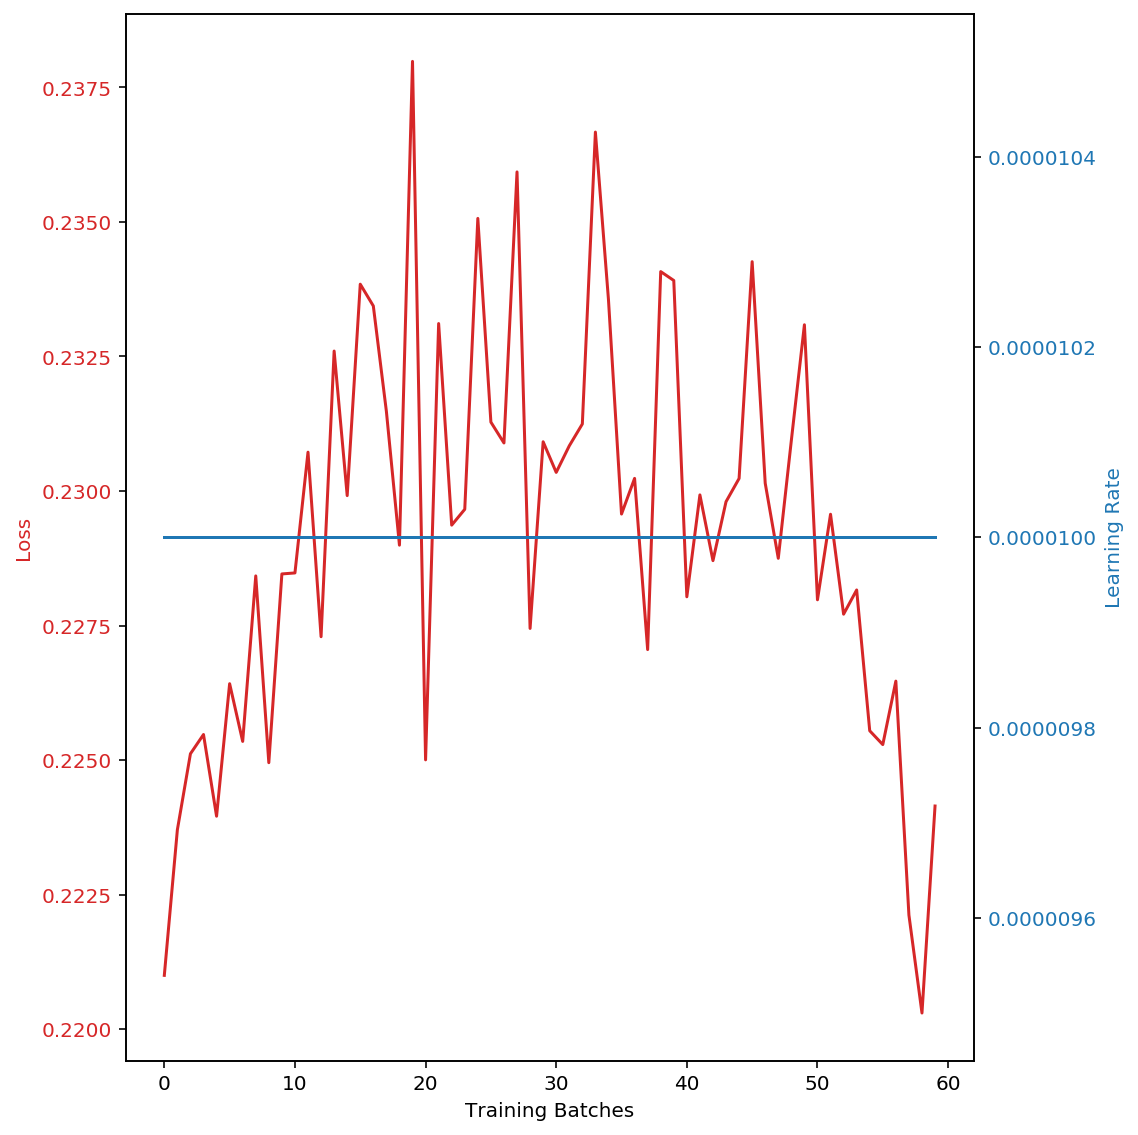

,id,proba,label
120,5219,0.501,1
797,25193,0.549,1
568,10287,0.475,0
264,79316,0.481,0
202,27496,0.521,1


In [12]:
epochs = 15
batch_size=128
kfold = False
submission, text_model, val_stats = train_and_predict(
    (model, optimizer),
    data,
    batch_size,
    epochs,
    scheduler_init_fn=None,
    model_call_back=reg_sched, # reg_sched
    validation_epochs=[2, 5, 7, 10, 15, 20, 26, 30, 35, 40, 46, 51, 54, 60, 65, 70],
    show_model_stats=False,
    accumulation_steps=16,
    sampling_policy="uda_without_replacement",
    consistency_loss_weight=minor_consistency_loss_weight, num_classes=num_classes,
    aug_1=aug_sample, aug_2=aug_sample,
)
submission.to_csv("submission_2.csv",index=False)
submission.sample(5)
